# Sentimental Vasco

Analysis of sentiments expressed in July by the supporters of Vasco da Gama. The sentiments were obtained after scrapped commentaries of a fan website. After that, several models and methods were tried to find the best accuracy (82% with a SGD Classifier).

## Table of Contents

1. Trained model loading
2. Wordcloud insights
3. How words affect sentiments
4. Sentiments over time

In [1]:
import joblib
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import normalize
import numpy as np
from textwrap import wrap

model = joblib.load('../model/vasco_model.sav')
model

SGDClassifier(loss='log_loss', n_jobs=-1, warm_start=True)

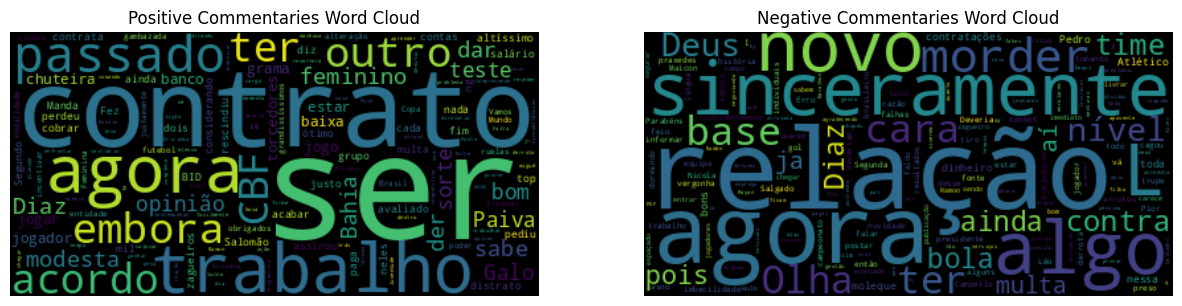

In [2]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from stop_words import get_stop_words

commentaries = pd.read_csv('../scrapper/commentaries.csv')
positive_commentaries = commentaries[commentaries['score'] == 1]['commentary']
negative_commentaries = commentaries[commentaries['score'] == 0]['commentary']

sample_positive = ' '.join(text for text in positive_commentaries.sample(frac=0.1, random_state=32))
sample_negative = ' '.join(text for text in negative_commentaries.sample(frac=0.1, random_state=42))

stop_words = get_stop_words('portuguese')
stop_words.extend(['Vasco', 'é', 'pra', 'caso', 'vai', 'deu', 'vão', 'clube', 'ca'])

wordcloud_positive = WordCloud(stopwords=stop_words).generate(sample_positive)
wordcloud_negative = WordCloud(stopwords=stop_words).generate(sample_negative)

plt.figure(figsize=(15, 7.5))

plt.subplot(1, 2, 1)
plt.imshow(wordcloud_positive, interpolation='bilinear')
plt.title('Positive Commentaries Word Cloud')
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(wordcloud_negative, interpolation='bilinear')
plt.title('Negative Commentaries Word Cloud')
plt.axis("off")

plt.show()

In [3]:
# Load the trained model
model = joblib.load('../model/vasco_model.sav')

# Assuming X_df is the DataFrame with the features (tokens)
X_df = pd.read_feather('../model/preprocessed_data/x_new.feather')
tokens = X_df.columns

# Initialize an empty DataFrame to store the importances
importances_df = pd.DataFrame(index=tokens)

sgd_coefficients = model.coef_.flatten()
importances_df['sgd_importance'] = sgd_coefficients

# Sort by importance
importances_df = importances_df.sort_values(by='sgd_importance', ascending=False)

# Filter top positive and negative tokens for plotting
top_pos_tokens = importances_df.head(15)
top_neg_tokens = importances_df.tail(17)

# Combine top positive and negative for plotting
top_tokens = pd.concat([top_pos_tokens, top_neg_tokens])

# top_tokens.to_csv('top_tokens.csv')

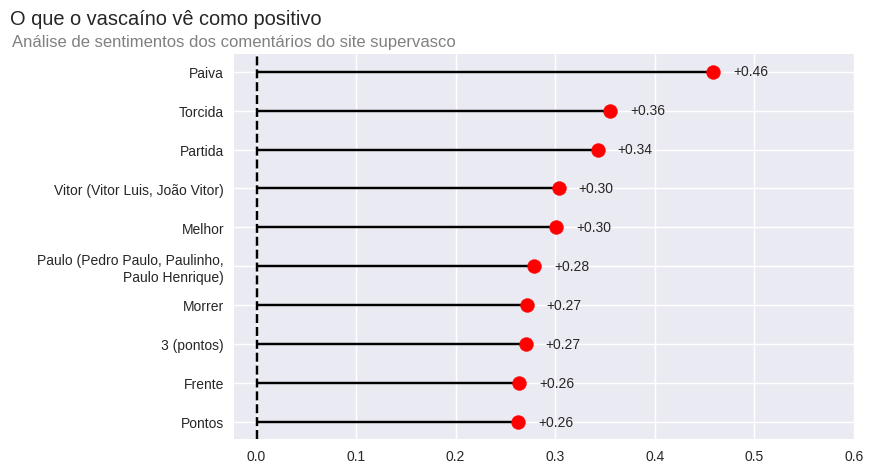

In [178]:
# Load the top tokens importance data
top_tokens = pd.read_csv('top_tokens.csv', index_col=0)


pos_tokens = top_tokens.sort_values(['sgd_importance']).tail(10)

normalized_importance = normalize([np.array(pos_tokens['sgd_importance'])])[0]

labels = [ '\n'.join(wrap(l, 30)) for l in pos_tokens['stemmer_pt'] ]


# Plot
plt.style.use('seaborn-v0_8')
plt.figure(figsize=(8, 5))
plt.scatter(normalized_importance, labels, s=100, zorder=2, c='red')
plt.hlines(y=labels, xmin=0, xmax=normalized_importance, zorder=1, colors='black')
for i, v in enumerate(normalized_importance):
    plt.text(v+0.02, i, f"{v:+.2f}", va='center', ha='left')

plt.xticks(np.arange(0, 0.65, 0.1))
plt.rcParams.update({'figure.titlesize': 'x-large'})

plt.axvline(x=0, color='black', linestyle='--')
plt.xlabel('')
plt.suptitle('O que o vascaíno vê como positivo', x=0.04, y=0.97)
plt.title('Análise de sentimentos dos comentários do site supervasco', x=0, y=1, c='gray')

plt.show()

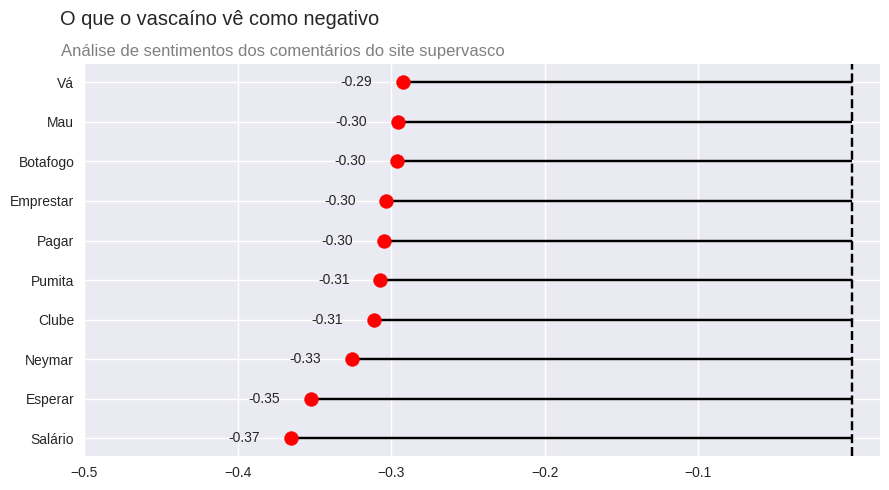

In [222]:
neg_tokens = top_tokens.sort_values(['sgd_importance']).head(10)

normalized_importance = normalize([np.array(neg_tokens['sgd_importance'])])[0]

labels = [ '\n'.join(wrap(l, 30)) for l in neg_tokens['stemmer_pt'] ]

# Plot
plt.style.use('seaborn-v0_8')
plt.figure(figsize=(9, 5))
plt.scatter(normalized_importance, labels, s=100, zorder=2, c='red')
plt.hlines(y=labels, xmin=0, xmax=normalized_importance, zorder=1, colors='black')
for i, v in enumerate(normalized_importance):
    plt.text(v-0.02, i, f"{v:+.2f}", va='center', ha='right')

plt.xticks(np.arange(-0.5, 0, 0.1))
plt.rcParams.update({'figure.titlesize': 'x-large'})

plt.axvline(x=0, color='black', linestyle='--')
plt.xlabel('')
plt.suptitle('O que o vascaíno vê como negativo', x=0.25, y=0.97)
plt.title('Análise de sentimentos dos comentários do site supervasco', x=0.25, y=1, c='gray')

plt.tight_layout()

plt.show()

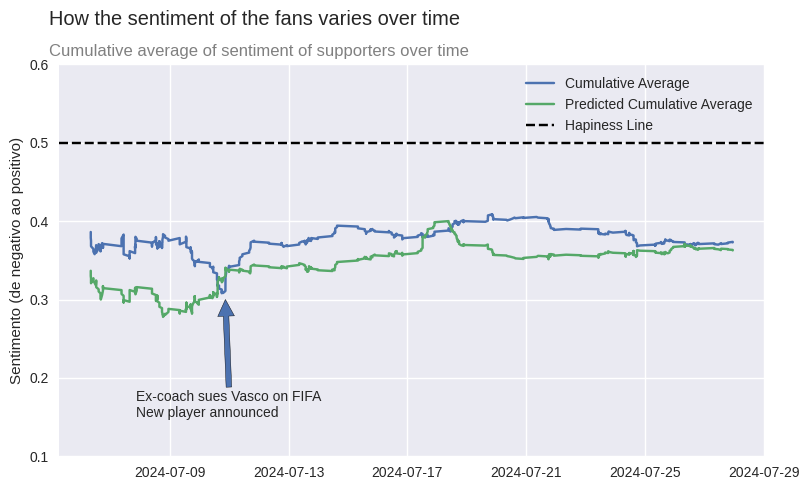

In [224]:
X = pd.read_feather('../model/preprocessed_data/x_new.feather')
y = pd.read_csv('../model/preprocessed_data/y_new.csv')

pages = pd.read_csv('../scrapper/pages.csv', parse_dates=[1])
pages = pages[['new_id', 'datetime']].join(y.set_index('pg_index'), how='right')[['new_id', 'datetime', 'score']].iloc[::-1]
y_pred = model.predict(X)
pages['predicted_score'] = y_pred
cumulative_average = pages[['predicted_score', 'score']].expanding().mean()

cumulative_average = cumulative_average.rename(columns={'predicted_score': 'cum_pred_score', 'score': 'cum_score'})
pages = pd.concat([pages, cumulative_average], axis=1)
pages = pages.iloc[100:]

fig, ax = plt.subplots(figsize=(8, 5))


ax.plot(pages['datetime'], pages['cum_score'], label='Cumulative Average')
ax.plot(pages['datetime'], pages['cum_pred_score'], label='Predicted Cumulative Average')

ax.set_yticks(np.arange(0.1, 0.7, 0.1))

plt.suptitle('How the sentiment of the fans varies over time', x=0.3, y=0.97)
plt.title('Cumulative average of sentiment of supporters over time', x=0.283, c='gray')

ax.axhline(0.5, color='black', linestyle='--', label='Hapiness Line')

ax.legend(loc='upper right')
    
plt.tight_layout()
ax.set_ylabel('Sentimento (de negativo ao positivo)')

ax.annotate('Ex-coach sues Vasco on FIFA\nNew player announced',
            xy=(pd.Timestamp('2024-07-11'), 0.3),
            xytext=(pd.Timestamp('2024-07-08'), 0.15),
            arrowprops={})

plt.show()